# Filters with Multiple Inputs and Multiple Outputs

*This notebook uses [[Wefers, 2015]](README.md) as reference.*

Along with single-input single-ouput (SISO) systems, systems can also be designed that have single-input multiple-output (SIMO), multiple-input single-output (MISO) and multiple-input multiple-output (MIMO) using transform based convolution. This can be efficient because the input and outputs only have to be transformed once, and the rest of the processing can be done in the frequency domain. 

Listed below are some assumptions that are made for the filters described in this notebook:

* All input and output streams share a common sample rate $F_s$.
* All input and output streams share a common block length $B$.
* All input and output blocks and filters must be transformed using a common transform size $K$.
* The relationship $K \ge B + \left( \underset{i, \, j}{max} \, \, N_{i \rightarrow j} \right) - 1$ must be true, where $\left( \underset{i, \, j}{max} \, \, N_{i \rightarrow j} \right)$ is the maximum length FIR filter connecting input $i$ to output $j$. If this is not true, time-aliasing will occur.

## Dual Channel Convolution

An increase in performance can be realized using a dual channel convolution method where two real channels are combined into a single complex channel before the transform is applied. This can be used for systems that have one input with two filters that need to be applied separately, such as in binaural synthesis where separate head-related impulse responses (HRIR) need to be applied to the same input. Another use case for dual channel convolution is when there are two inputs that need the have the same filter applied to them.

To apply the dual channel convolution method, two real inputs $x_0(n)$ and $x_1(n)$ are transformed into a complex-value signal $x(n)$ as follows:

$$x(n) \, = \, x_0(n) + i \, x_1(n)$$

The $K$-point DFT is then taken on the complex signal $x(n)$, resulting in:

$$DFT_{(k)} \{x(n)\} \quad \Rightarrow \quad X(k) = X_0(k) + i \, X_1(k)$$

The real and imaginary parts of the of the DFT spectra can then be extracted using the following equations:

$$X_0(k) \, = \, \frac{1}{2} \left[ X(k) + \overline{X(K-k)} \right]$$
$$X_1(k) \, = \, \frac{i}{2} \left[ X(k) - \overline{X(K-k)} \right]$$

The following dual channel convolution examples are demonstrated below:
1. Apply separate filters to the same input
1. Apply the same filter to separate inputs

In [1]:
import numpy as np

def partition_input(input, B):
    """Partition input sequence of arbitrary size into blocks of length B. 
    The last block is zero padded if the input is not equally divisible by B.
    """
    block_cnt = int(np.ceil(len(input) / B))
    zero_pad_cnt = block_cnt * B - len(input)
    zero_padded_input = np.pad(input, (0, zero_pad_cnt))
    partitioned_input = np.reshape(zero_padded_input, (block_cnt, B))
    return partitioned_input

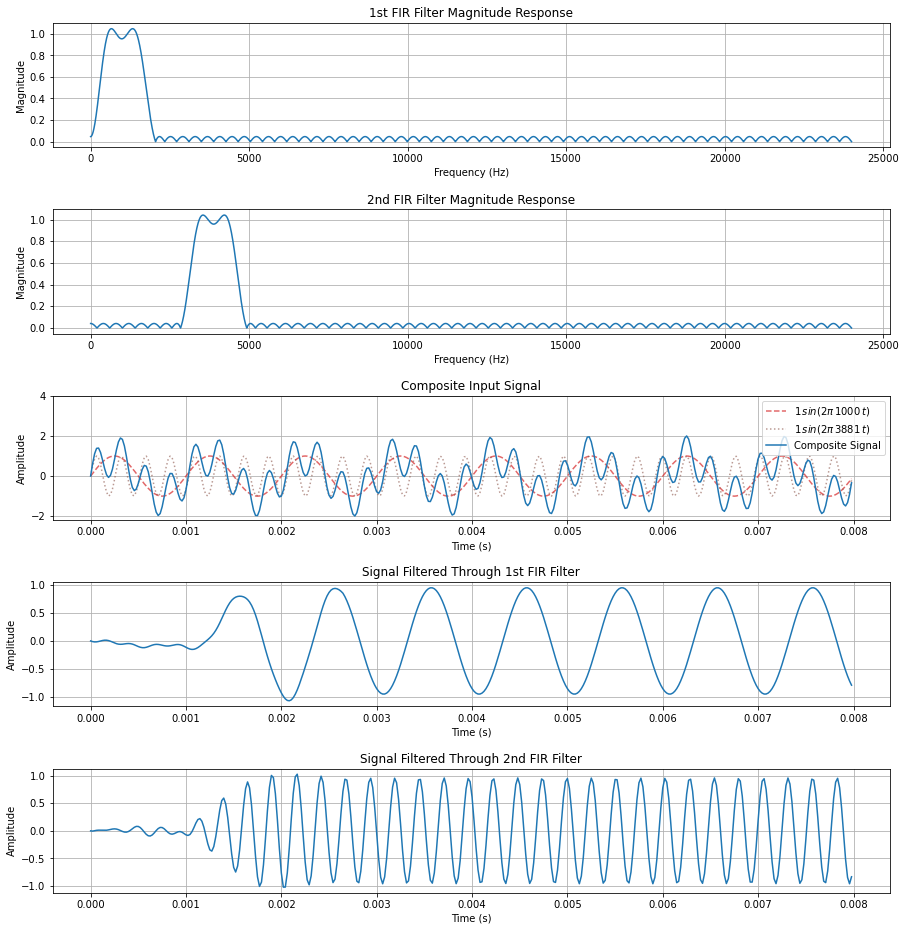

In [2]:
# Dual Channel Convolution Example
#  Apply separate filters the same input channel

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import remez, freqz
from scipy.fft import fft, ifft

# Sample rate and period
Fs = 48e3
Ts = 1/Fs

# Number of input samples per block
B = 128

# Number of FFT bins
K = 256

# Number of filter taps
N = 128

assert N+B-1 <= K, 'Number of FFT bins K must increase, otherwise there will be time aliasing'

# Number of blocks to process
num_blocks = 3
n = np.arange(0, num_blocks*B)

# Input signal
# Signal in passband of 1st filter and in stopband of the 2nd filter
A0 = 1
f0 = 1000
x0 = A0 * np.sin(2*np.pi*f0*n*Ts)
# Signal in passband of 2nd filter and in stopband of the 1st filter
A1 = 1
f1 = 3881
x1 = A1 * np.sin(2*np.pi*f1*n*Ts)
# Composite signal
x = x0 + x1

# Partition the input signal into blocks and zero pad
x_part = partition_input(x, B)

# Create 1st FIR filter using the Remez exchange algorithm
band_0 = [f0 - 500, f0 + 500]  # Desired pass band, Hz
trans_width_0 = 500   # Width of transition from pass band to stop band, Hz
edges_0 = [0, band_0[0] - trans_width_0, band_0[0], band_0[1],
         band_0[1] + trans_width_0, Fs/2]
h0 = remez(N, edges_0, [0, 1, 0], fs=Fs)

# Create 2nd FIR filter using the Remez exchange algorithm
band_1 = [f1 - 500, f1 + 500]  # Desired pass band, Hz
trans_width_1 = 500   # Width of transition from pass band to stop band, Hz
edges_1 = [0, band_1[0] - trans_width_1, band_1[0], band_1[1],
         band_1[1] + trans_width_1, Fs/2]
h1 = remez(N, edges_1, [0, 1, 0], fs=Fs)

# Calculate the frequency responses of the designed filters with 1 Hz resolution
f0_freqz, h0_freqz = freqz(h0, [1], worN=int(Fs), fs=Fs)
f1_freqz, h1_freqz = freqz(h1, [1], worN=int(Fs), fs=Fs)

# Combine each filters impulse responses into a single complex impulse response
h = h0 + 1j * h1 

# Zero pad filter coefficients and calculte the FFT
# (Used for frequency domain filtering)
h_zp = np.pad(h, (0, K-N))
h_fft = fft(h_zp)

# Initialize input sliding window and output arrays
input_sliding_window = np.zeros(K)
y_arr = np.zeros((num_blocks, B), dtype=np.complex128)

# Filter data using the overlap-save method
for block in range(num_blocks):
    input_sliding_window = np.pad(input_sliding_window,(0,B))[B:]
    input_sliding_window[-B:] = x_part[block, :]
    x_fft = fft(input_sliding_window)
    filtered_fft = h_fft * x_fft
    ifft_result = ifft(filtered_fft)
    y_arr[block, :] = ifft_result[-B:]

# Convert outputs to a 1D arrays
y0 = np.real(y_arr.flatten())
y1 = np.imag(y_arr.flatten())

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 16))

# Plot frequency response of 1st filter
ax[0].grid()
ax[0].plot(f0_freqz, np.abs(h0_freqz))
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Magnitude')
ax[0].set_title('1st FIR Filter Magnitude Response')

# Plot frequency response of 2nd filter
ax[1].grid()
ax[1].plot(f1_freqz, np.abs(h1_freqz))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Magnitude')
ax[1].set_title('2nd FIR Filter Magnitude Response')

# Plot composite input signal
ax[2].grid()
ax[2].plot(n*Ts, x0, '--', c='C3', alpha=0.7, label=r'${} \, sin(2 \pi \, {} \, t)$'.format(A0, f0))
ax[2].plot(n*Ts, x1, ':', c='C5', alpha=0.6, label=r'${} \, sin(2 \pi \, {} \, t)$'.format(A1, f1))
ax[2].plot(n*Ts, x, c='C0', label='Composite Signal')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Amplitude')
ax[2].set_title('Composite Input Signal')
ax[2].set_ylim(top=2*(A0 + A1))
ax[2].legend(loc='upper right')

# Plot signal filtered through 1st filter
ax[3].grid()
ax[3].plot(n*Ts, y0)
ax[3].set_xlabel('Time (s)')
ax[3].set_ylabel('Amplitude')
ax[3].set_title('Signal Filtered Through 1st FIR Filter')

# Plot signal filtered through 2nd filter
ax[4].grid()
ax[4].plot(n*Ts, y1)
ax[4].set_xlabel('Time (s)')
ax[4].set_ylabel('Amplitude')
ax[4].set_title('Signal Filtered Through 2nd FIR Filter')

plt.subplots_adjust(hspace=0.5)
pass

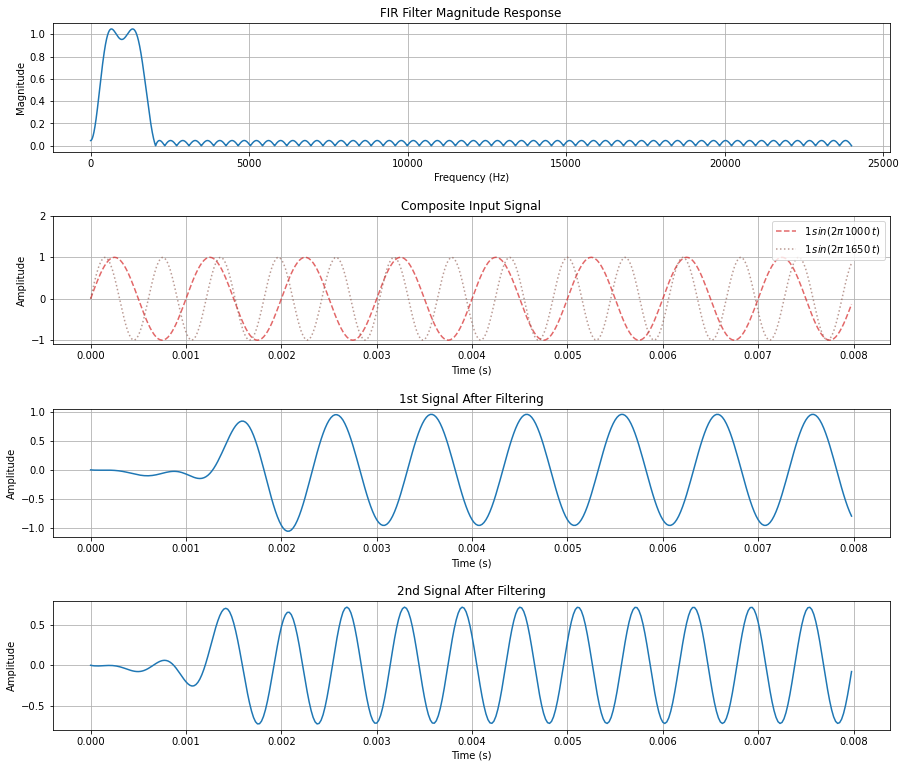

In [3]:
# Dual Channel Convolution Example
#  Apply the same filter to separate input channels

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import remez, freqz
from scipy.fft import fft, ifft

# Sample rate and period
Fs = 48e3
Ts = 1/Fs

# Number of input samples per block
B = 128

# Number of FFT bins
K = 256

# Number of filter taps
N = 128

assert N+B-1 <= K, 'Number of FFT bins K must increase, otherwise there will be time aliasing'

# Number of blocks to process
num_blocks = 3
n = np.arange(0, num_blocks*B)

# Channel 1 signal 
A0 = 1
f0 = 1000
x0 = A0 * np.sin(2*np.pi*f0*n*Ts)

# Channel 2 signal 
A1 = 1
f1 = 1650
x1 = A1 * np.sin(2*np.pi*f1*n*Ts)

# Combine channel 1 and channel 2 into a complex signal
x = x0 + 1j * x1

# Partition the input signal into blocks and zero pad
x_part = partition_input(x, B)

# Create FIR filter using the Remez exchange algorithm
band = [f0 - 500, f0 + 500]  # Desired pass band, Hz
trans_width = 500   # Width of transition from pass band to stop band, Hz
edges = [0, band[0] - trans_width, band[0], band[1],
         band[1] + trans_width, Fs/2]
h = remez(N, edges, [0, 1, 0], fs=Fs)

# Calculate the frequency response of the designed filter with 1 Hz resolution
f_freqz, h_freqz = freqz(h, [1], worN=int(Fs), fs=Fs)

# Zero pad filter coefficients and calculte the FFT
# (Used for frequency domain filtering)
h_zp = np.pad(h, (0, K-N))
h_fft = fft(h_zp)

# Initialize input sliding window and output arrays
input_sliding_window = np.zeros(K, dtype=np.complex128)
y_arr = np.zeros((num_blocks, B), dtype=np.complex128)

# Filter data using the overlap-save method
for block in range(num_blocks):
    input_sliding_window = np.pad(input_sliding_window,(0,B))[B:]
    input_sliding_window[-B:] = x_part[block, :]
    x_fft = fft(input_sliding_window)
    filtered_fft = h_fft * x_fft
    ifft_result = ifft(filtered_fft)
    y_arr[block, :] = ifft_result[-B:]

# Convert outputs to a 1D arrays
y0 = np.real(y_arr.flatten())
y1 = np.imag(y_arr.flatten())

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 13))

# Plot frequency response of filter
ax[0].grid()
ax[0].plot(f_freqz, np.abs(h_freqz))
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Magnitude')
ax[0].set_title('FIR Filter Magnitude Response')

# Plot composite input signal
ax[1].grid()
ax[1].plot(n*Ts, x0, '--', c='C3', alpha=0.7, label=r'${} \, sin(2 \pi \, {} \, t)$'.format(A0, f0))
ax[1].plot(n*Ts, x1, ':', c='C5', alpha=0.6, label=r'${} \, sin(2 \pi \, {} \, t)$'.format(A1, f1))
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Composite Input Signal')
ax[1].set_ylim(top=2*max(A0, A1))
ax[1].legend(loc='upper right')

# Plot filtered 1st signal
ax[2].grid()
ax[2].plot(n*Ts, y0)
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Amplitude')
ax[2].set_title('1st Signal After Filtering')

# Plot filtered 2nd signal
ax[3].grid()
ax[3].plot(n*Ts, y1)
ax[3].set_xlabel('Time (s)')
ax[3].set_ylabel('Amplitude')
ax[3].set_title('2nd Signal After Filtering')

plt.subplots_adjust(hspace=0.5)
pass